# VAE
This VAE implementation was adapted from:
https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [27]:
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hw5 import seed_everything, load_data, plot_grid, get_sample_images

In [28]:
# -=-=-= DataLoader Parameters =-=-=-
# Root directory for dataset
dataroot = "~/Documents/ML_Data/Danbooru2019_Portraits/"
# Image size
image_size = 64
# Seed to use for displaying the same images
data_seed = 42
# Number of workers for dataloader
dataloader_workers = 2
# Batch size during training
batch_size = 128

Using device:  cuda:0


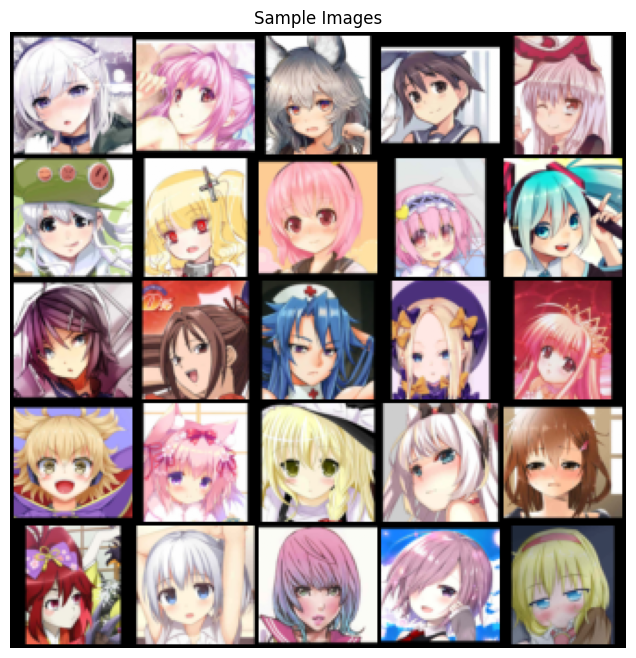

In [29]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Set random seed for the data
seed_everything(data_seed)

# Creating dataloaders
dataset = load_data(dataroot, image_size=image_size, augment=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=dataloader_workers)

# Plot some sample images
images, _, _ = get_sample_images(dataloader, 25)
plot_grid(images, title="Sample Images")

In [30]:
# The VAE model does not have convolutional layers, so we need to flatten the images
def flatten(x):
    return torch.flatten(x, 1)

def back_to_image(x):
    return x.view(-1, 3, image_size, image_size)

flatten_images = flatten(images)

In [31]:
class VAE(nn.Module):

    def __init__(self, input_dim, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 417921.819: 100%|██████████| 50/50 [3:38:35<00:00, 262.31s/it]  


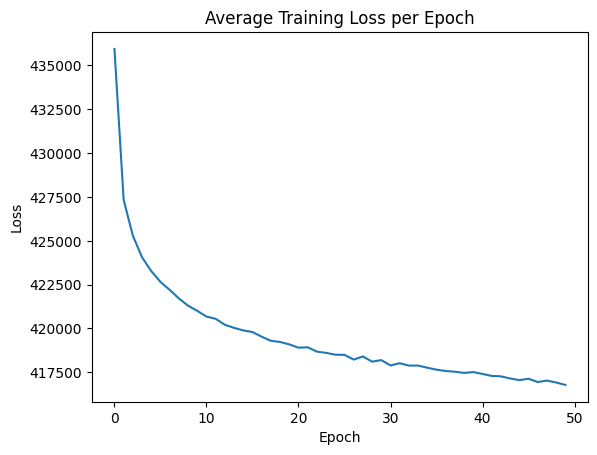

In [32]:
def train_vae(net, optimizer, max_epochs, device):
    net.train()
    losses = []
    max_epochs = tqdm(range(max_epochs))
    for epoch in max_epochs:
        running_loss = 0.0
        for i, (x,_) in enumerate(dataloader, 0):
            x = flatten(x.to(device))

            optimizer.zero_grad()
            x_hat, mean, log_var = net(x)
            loss = loss_function(x_hat, x, mean, log_var)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses.append(loss.item())
            if i % 10 == 9:
                max_epochs.set_description(f"Loss: {running_loss/10:.3f}")
                running_loss = 0.0
        torch.save(net.state_dict(), "vae.pth")

    plt.title("Average Training Loss per Epoch")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    size_per_batch = int(np.ceil(len(dataloader.dataset) / dataloader.batch_size))
    plt.plot(np.mean(np.array(losses).reshape(-1, size_per_batch), axis=1))
    plt.show()

net = VAE(input_dim=image_size*image_size*3).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
train_vae(net, optimizer, max_epochs=50, device=device)

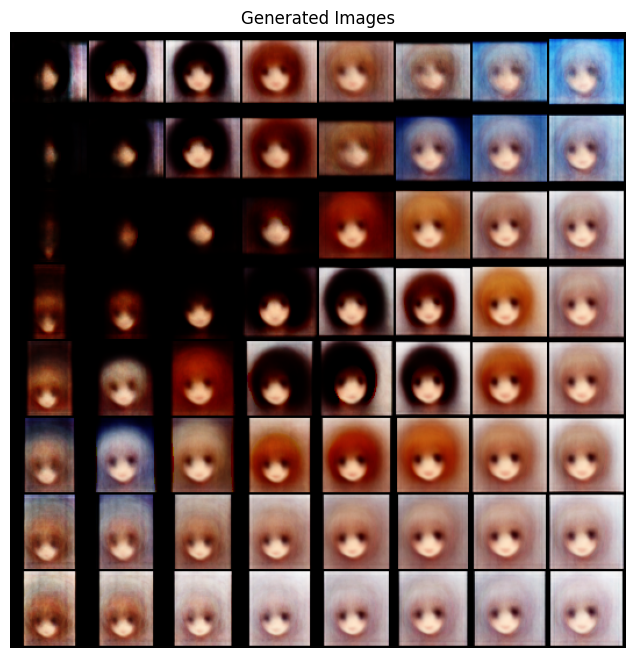

In [35]:
def load_model(model_path:str):
    net = VAE(input_dim=image_size*image_size*3).to(device)
    net.load_state_dict(torch.load(model_path))
    net.eval()
    return net

def generate_vae_image(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = net.decode(z_sample)
    image = back_to_image(x_decoded.detach().cpu())
    return image

def generate_vae_grid(n_images=64, scale=5):
    n = int(np.sqrt(n_images))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)
    # Sample some images
    images = torch.zeros((n_images, 3, image_size, image_size))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            images[i*n+j] = generate_vae_image(xi, yi) 
    return images

net = load_model("vae.pth")
plot_grid(generate_vae_grid(scale=5), title="Generated Images")

We can see the original VAE is not able to generate high quality images, but it is able to represent the
images as a distribution in the latent space. We can see this through the images morphing from one to another
as we move through the latent space.